In [ ]:
# Name : Avinash Kumar Pandey
# Assignment 2
# BMI NLP Course

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import gensim
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Set the display options to ensure all columns are shown
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)        # No max width
pd.set_option('display.max_colwidth', -1)  # For pandas versions >= 1.0

<ipython-input-80-a92e0564eb27>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # For pandas versions >= 1.0


In [ ]:
# IMPORTANT FUNCTIONS

# Preprocessing Function

def preprocess(text):
    if pd.isnull(text):
        return ''
    tokens = nltk.word_tokenize(text)
    filtered = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered)

# Bootstrapping Function for computing confidence intervals of F1-score

def bootstrap_f1_macro(clf, X, y, n_iterations=1000, ci=0.95):
    scores = []
    for _ in range(n_iterations):
        # Sampling with replacement
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_resampled = X[indices]
        y_resampled = y[indices]

        # Predict and compute F1 macro score
        y_pred = clf.predict(X_resampled)
        score = f1_score(y_resampled, y_pred, average='macro')
        scores.append(score)

    # Sort scores and get percentiles for confidence interval
    lower_bound = (1.0 - ci) / 2.0
    upper_bound = 1.0 - lower_bound
    lower, upper = np.percentile(scores, [lower_bound*100, upper_bound*100])

    return lower, upper


# Functions for word cluster feature

def fit_word_clusters(df):
    # Tokenize and train Word2Vec
    sentences = df['fall_description'].apply(word_tokenize).tolist()
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    # Get word vectors for all words in vocabulary
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}

    # Cluster words using K-means
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(list(word_vectors.values()))

    return model, kmeans

def transform_word_clusters(df, model, kmeans):
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
    num_clusters = kmeans.n_clusters

    # Get the cluster assignment for each word
    word_cluster_assignment = {word: kmeans.predict([vector])[0] for word, vector in word_vectors.items()}

    # Define the transform function
    def get_cluster_representation(text):
        tokens = word_tokenize(text)
        clusters = [word_cluster_assignment.get(token, -1) for token in tokens if token in word_cluster_assignment]
        representation = np.bincount(clusters, minlength=num_clusters)
        return representation[:10]

    # Transform the dataframe
    cluster_features = df['fall_description'].apply(get_cluster_representation)
    array_representation = np.array(cluster_features.tolist())

    return array_representation




In [ ]:
## CLASSIFIER TRAINING, HYPERPARAMETER TUNING & PERFORMANCE COMPARISON

# Training Data Upload
df = pd.read_csv("/content/fallreports_2023-9-21_train.csv")
df = df.dropna(subset=['fall_description'])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['fall_description'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df['fall_description'] = df['fall_description'].apply(preprocess)

# Preprocessed word length of fall description
df['processed_text_length'] = df['fall_description'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df['unique_word_count'] = df['fall_description'].apply(lambda x: len(set(word_tokenize(x))))

# Hyper parameter Tuning
df = df.dropna().reset_index(drop = True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# TF-IDF Vector
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(train_df['fall_description'])
X_test_tfidf = vectorizer.transform(test_df['fall_description'])

# Word Cluster Represenattion
model, kmeans = fit_word_clusters(train_df)  # Only on training data
train_clusters = transform_word_clusters(train_df, model, kmeans)
test_clusters = transform_word_clusters(test_df, model, kmeans)

# In training the models, variables from columns_to_use, word_cluster feature and TF-IDF vectors are used (combined using np.hstack)
columns_to_use = ['age_at_enrollment', 'moca_total', 'abc_total', 'fall_total','unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
X_train = np.hstack((X_train_tfidf.toarray(),train_clusters, train_df[columns_to_use].values))
X_test = np.hstack((X_test_tfidf.toarray(),test_clusters, test_df[columns_to_use].values))

# Initializing Final Features
y_train = train_df['fog_q_class']
y_test = test_df["fog_q_class"]

# Setting up classifiers and parameters for GridSearch
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(solver='liblinear') ,
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    'SVM': SVC(),
}

# Range of paramaters for Hyperparameter tuning
params = {
    'Naive Bayes': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Decision Tree': {
        'max_depth': [None, 3, 5, 10, 15, 20],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200,500],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 10],
    },
    'SVM': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf','poly','sigmoid']
    },
    'XGBoost': {
        'n_estimators': [10,50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 10],
    },

    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    }

# Model Performance Print (Test Data is 20% random split from "fallreports_2023-9-21_train.csv")
for model_name, model in models.items():
    grid_search = GridSearchCV(model, params[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    models[model_name].set_params(**grid_search.best_params_)
    predictions = grid_search.predict(X_test)
    print(model_name)
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Micro F1:", f1_score(y_test, predictions, average='micro'))
    print("Macro F1:", f1_score(y_test, predictions, average='macro'))
    print("------------")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Naive Bayes
Best Parameters: {'alpha': 0.01}
Accuracy: 0.6666666666666666
Micro F1: 0.6666666666666666
Macro F1: 0.6466346153846153
------------
Decision Tree
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.9761904761904762
Micro F1: 0.9761904761904762
Macro F1: 0.9744370054777846
------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression
Best Parameters: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.8809523809523809
Micro F1: 0.8809523809523809
Macro F1: 0.875222816399287
------------
Random Forest
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7619047619047619
Micro F1: 0.7619047619047619
Macro F1: 0.6920821114369501
------------
XGBoost
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.9761904761904762
Micro F1: 0.9761904761904762
Macro F1: 0.9744370054777846
------------
SVM
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.9285714285714286
Micro F1: 0.9285714285714286
Macro F1: 0.9251336898395721
------------


In [ ]:
# THIS CODE BLOCK IS FOR REFERNCE ONLY TO SHOW HOW TEST DATA FEATURES ARE CONSTRUCTED
# Constructing the Test Data from "/content/fallreports_2023-9-21_test.csv" to run the trained classifiers with optimal hyperparameters (shown separately for reference)

# Test Data Upload
df1 = pd.read_csv("/content/fallreports_2023-9-21_test.csv")
df1 = df1.dropna(subset=['fall_description'])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['fall_description'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df1['fall_description'] = df1['fall_description'].apply(preprocess)

# Preprocessed word length of fall description
df1['processed_text_length'] = df1['fall_description'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df1['unique_word_count'] = df1['fall_description'].apply(lambda x: len(set(word_tokenize(x))))

df1 = df1.dropna().reset_index(drop = True)
test_df = df1

# TF-IDF Vector
X_test_tfidf = vectorizer.transform(test_df['fall_description'])

# Word Cluster Represenattion
test_clusters = transform_word_clusters(test_df, model, kmeans)
columns_to_use = ['age_at_enrollment', 'moca_total', 'abc_total', 'fall_total','unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
#variables from columns_to_use list , word_cluster feature and TF-IDF vectors are used (combined using np.hstack)

X_test_1 = np.hstack((X_test_tfidf.toarray(),test_clusters, test_df[columns_to_use].values))

# Initializing Final Features
y_test_1 = test_df["fog_q_class"]

In [ ]:
# Testing the trained classifiers with optimal hyperparameters on "fallreports_2023-9-21_test.csv" data

# Test Data Upload
df1 = pd.read_csv("/content/fallreports_2023-9-21_test.csv")
df1 = df1.dropna(subset=['fall_description'])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['fall_description'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df1['fall_description'] = df1['fall_description'].apply(preprocess)

# Preprocessed word length of fall description
df1['processed_text_length'] = df1['fall_description'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df1['unique_word_count'] = df1['fall_description'].apply(lambda x: len(set(word_tokenize(x))))

df1 = df1.dropna().reset_index(drop = True)
test_df = df1

# TF-IDF Vector
X_test_tfidf = vectorizer.transform(test_df['fall_description'])

# Word Cluster Represenattion
test_clusters = transform_word_clusters(test_df, model, kmeans)
columns_to_use = ['age_at_enrollment', 'moca_total', 'abc_total', 'fall_total','unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
X_test = np.hstack((X_test_tfidf.toarray(),test_clusters, test_df[columns_to_use].values))

# Initializing Final Features
y_test = test_df["fog_q_class"]

# Using Optimal tuned Hyperparameters
classifiers = {
    "Naive Bayes": MultinomialNB(alpha=0.01),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2),
    "Logistic Regression": LogisticRegression(C=1, penalty='l2', max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=200),
    "XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(C=0.1, kernel='linear', probability=True)
}

# Output performance of the classifiers on test data from  "fallreports_2023-9-21_test.csv"
for clf_name, clf in classifiers.items() :

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    print("-------------------------------------------------------------")
    print(clf_name)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Micro F1:", f1_score(y_test, predictions, average='micro'))
    print("Macro F1:", f1_score(y_test, predictions, average='macro'))

    lower, upper = bootstrap_f1_macro(clf, X_test, y_test)
    print(f"95% confidence interval of F1 macro score: ({lower:.4f}, {upper:.4f})")


-------------------------------------------------------------
Naive Bayes
Accuracy: 0.7272727272727273
Micro F1: 0.7272727272727273
Macro F1: 0.7124183006535949
95% confidence interval of F1 macro score: (0.5580, 0.8368)
-------------------------------------------------------------
Decision Tree
Accuracy: 0.9772727272727273
Micro F1: 0.9772727272727273
Macro F1: 0.9750990379173741
95% confidence interval of F1 macro score: (0.9162, 1.0000)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-------------------------------------------------------------
Logistic Regression
Accuracy: 0.9545454545454546
Micro F1: 0.9545454545454546
Macro F1: 0.9494252873563218
95% confidence interval of F1 macro score: (0.8664, 1.0000)
-------------------------------------------------------------
Random Forest
Accuracy: 0.8181818181818182
Micro F1: 0.8181818181818182
Macro F1: 0.7708333333333334
95% confidence interval of F1 macro score: (0.6143, 0.9062)
-------------------------------------------------------------
XGBoost
Accuracy: 0.9772727272727273
Micro F1: 0.9772727272727273
Macro F1: 0.9750990379173741
95% confidence interval of F1 macro score: (0.9116, 1.0000)
-------------------------------------------------------------
SVM
Accuracy: 0.9545454545454546
Micro F1: 0.9545454545454546
Macro F1: 0.9494252873563218
95% confidence interval of F1 macro score: (0.8610, 1.0000)


In [ ]:
# Ensemble Classifier
from sklearn.ensemble import VotingClassifier

# Initialize the individual models with their best parameters
naive_bayes = MultinomialNB(alpha=0.01)
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2)
logistic_regression = LogisticRegression(C=1, penalty='l2')
random_forest = RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=200)
xgboost = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss")
svm = SVC(C=0.1, kernel='linear', probability=True)  # probability=True is required for soft voting

# Create an ensemble of the models using soft voting
ensemble = VotingClassifier(estimators=[
    ('naive_bayes', naive_bayes),
    ('decision_tree', decision_tree),
    ('logistic_regression', logistic_regression),
    ('random_forest', random_forest),
    ('xgboost', xgboost),
    ('svm', svm)
], voting='soft')

# Train and evaluate the ensemble
ensemble.fit(X_train, y_train)
ensemble_predictions = ensemble.predict(X_test) # Test data is from   "fallreports_2023-9-21_test.csv" and not the 80-20 test data split

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_micro_f1 = f1_score(y_test, ensemble_predictions, average='micro')
ensemble_macro_f1 = f1_score(y_test, ensemble_predictions, average='macro')

print("\nEnsemble Classifier:")
print("Accuracy:", ensemble_accuracy)
print("Micro F1:", ensemble_micro_f1)
print("Macro F1:", ensemble_macro_f1)
lower, upper = bootstrap_f1_macro(clf, X_test, y_test)
print(f"95% confidence interval of F1 macro score: ({lower:.4f}, {upper:.4f})")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Ensemble Classifier:
Accuracy: 0.9545454545454546
Micro F1: 0.9545454545454546
Macro F1: 0.9494252873563218
95% confidence interval of F1 macro score: (0.9162, 1.0000)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

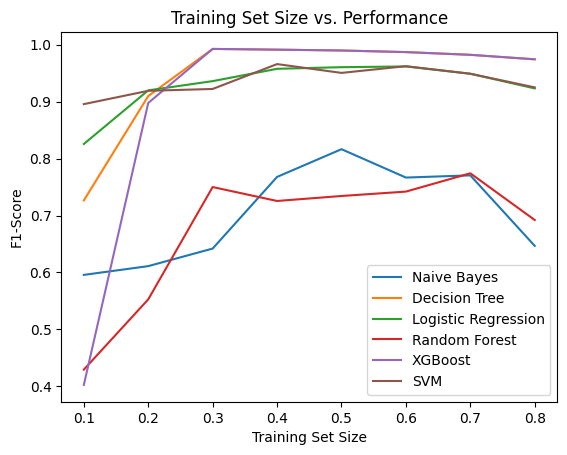

In [ ]:
# Train Size Performance Variation Study

# Define classifiers and their respective hyperparameters
classifiers = {
    "Naive Bayes": MultinomialNB(alpha=0.01),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2),
    "Logistic Regression": LogisticRegression(C=1, penalty='l2', max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=200),
    "XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(C=0.1, kernel='linear', probability=True)
}

# Training set size vs. performance
sizes = [i/10 for i in range(1,9)]

for clf_name, clf in classifiers.items():
    performance = []
    for size in sizes:

      train_df, test_df = train_test_split(df, train_size= size, random_state=42) # HERE TEST DATA IS FROM THE TRAINING DATA SPLIT
      # TF-IDF Vector
      vectorizer = TfidfVectorizer(ngram_range=(1, 3))
      X_train_tfidf = vectorizer.fit_transform(train_df['fall_description'])
      X_test_tfidf = vectorizer.transform(test_df['fall_description'])

      # Word Cluster Represenattion
      model, kmeans = fit_word_clusters(train_df)  # Only on training data
      train_clusters = transform_word_clusters(train_df, model, kmeans)
      test_clusters = transform_word_clusters(test_df, model, kmeans)
      columns_to_use = ['age_at_enrollment', 'moca_total', 'abc_total', 'fall_total','unique_word_count','processed_text_length','sentiment']

      # Combining Vectors & Features
      X_train = np.hstack((X_train_tfidf.toarray(),train_clusters, train_df[columns_to_use].values))
      X_test = np.hstack((X_test_tfidf.toarray(),test_clusters, test_df[columns_to_use].values))

      # Initializing Final Features
      y_train = train_df['fog_q_class']
      y_test = test_df["fog_q_class"]

      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)

      performance.append(f1_score(y_test, y_pred, average = 'macro'))

    plt.plot(sizes, performance, label=clf_name)

plt.xlabel("Training Set Size")
plt.ylabel("F1-Score")
plt.title("Training Set Size vs. Performance")
plt.legend()
plt.show()


In [ ]:
# Ablation
classifiers = {

    "XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"), # Ablation Study on Best Classifier Only

}

features = [ 'age_at_enrollment','abc_total','moca_total', 'fall_total','unique_word_count','processed_text_length','sentiment'] # Ablation Study on these features

# Training set size vs. performance
for clf_name, clf in classifiers.items():
  for feature in features:
    print("----------------------------------")
    print("Omitted Feature")
    print(feature)
    print("-----------------------------------")

    columns_to_use = [ 'age_at_enrollment','abc_total','moca_total', 'fall_total','unique_word_count','processed_text_length','sentiment']
    columns_to_use.remove(feature)

    # Combining Vectors & Features
    X_train = np.hstack((X_train_tfidf.toarray(),train_clusters, train_df[columns_to_use].values))
    X_test = np.hstack((X_test_tfidf.toarray(),test_clusters, test_df[columns_to_use].values))

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print("Accuracy:", accuracy)
    print("Micro F1:", micro_f1)
    print("Macro F1:", macro_f1)
    lower, upper = bootstrap_f1_macro(clf, X_test, y_test)
    print(f"95% confidence interval of F1 macro score: ({lower:.4f}, {upper:.4f})")

----------------------------------
Omitted Feature
age_at_enrollment
-----------------------------------
Accuracy: 0.9090909090909091
Micro F1: 0.9090909090909091
Macro F1: 0.9017857142857143
95% confidence interval of F1 macro score: (0.7905, 0.9767)
----------------------------------
Omitted Feature
abc_total
-----------------------------------
Accuracy: 0.9772727272727273
Micro F1: 0.9772727272727273
Macro F1: 0.9750990379173741
95% confidence interval of F1 macro score: (0.9073, 1.0000)
----------------------------------
Omitted Feature
moca_total
-----------------------------------
Accuracy: 0.9772727272727273
Micro F1: 0.9772727272727273
Macro F1: 0.9750990379173741
95% confidence interval of F1 macro score: (0.9162, 1.0000)
----------------------------------
Omitted Feature
fall_total
-----------------------------------
Accuracy: 0.9318181818181818
Micro F1: 0.9318181818181818
Macro F1: 0.9228521332554062
95% confidence interval of F1 macro score: (0.8182, 1.0000)
--------------